In [1]:
from google.colab import drive
import os

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -q pycocotools albumentations

In [3]:
import tarfile

data_tar_path = '/content/drive/MyDrive/cv_hw3_data/hw3-data-release.tar'
extract_folder = './hw3_data_release'

if not os.path.exists(extract_folder):
    with tarfile.open(data_tar_path) as tar:
        tar.extractall(path=extract_folder)
    print('解壓完成！')
else:
    print('資料已存在，略過解壓縮')

解壓完成！


In [4]:
import shutil

source_path = '/content/drive/MyDrive/cv_hw3_data/utils.py'
destination_path = './utils.py'

try:
    shutil.copy2(source_path, destination_path)
    print(f"File '{source_path}' copied successfully to '{destination_path}'")
except FileNotFoundError:
    print(f"Error: Source file '{source_path}' not found.")
except Exception as e:
    print(f"An error occurred: {e}")


File '/content/drive/MyDrive/cv_hw3_data/utils.py' copied successfully to './utils.py'


In [5]:
import json
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.models.detection import maskrcnn_resnet50_fpn
import torchvision.transforms.functional as TF
import numpy as np
from PIL import Image
from utils import encode_mask, decode_maskobj, read_maskfile
from tqdm import tqdm
import skimage.io as sio
from torchvision.ops import masks_to_boxes

In [6]:
# --- 4. 定義Dataset類別（無資料增強） ---
class CellDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.image_folders = sorted(os.listdir(root_dir))

    def __getitem__(self, idx):
        folder_name = self.image_folders[idx]
        folder_path = os.path.join(self.root_dir, folder_name)
        img = Image.open(os.path.join(folder_path, 'image.tif')).convert('RGB')
        img_tensor = TF.to_tensor(img)

        masks = []
        labels = []
        for class_idx in range(1, 5):
            mask_path = os.path.join(folder_path, f'class{class_idx}.tif')
            if os.path.exists(mask_path):
                mask = sio.imread(mask_path)
                instance_ids = np.unique(mask)
                instance_ids = instance_ids[instance_ids != 0]
                for id in instance_ids:
                    binary_mask = (mask == id).astype(np.uint8)
                    masks.append(torch.tensor(binary_mask, dtype=torch.uint8))
                    labels.append(class_idx)

        if len(masks) == 0:
            masks_tensor = torch.zeros((1, img_tensor.shape[1], img_tensor.shape[2]), dtype=torch.uint8)
            labels_tensor = torch.tensor([0], dtype=torch.int64)
        else:
            masks_tensor = torch.stack(masks, dim=0)
            labels_tensor = torch.tensor(labels, dtype=torch.int64)

        from torchvision.ops import masks_to_boxes
        if masks_tensor.numel() > 0:
            boxes = masks_to_boxes(masks_tensor)
        else:
            boxes = torch.zeros((0, 4), dtype=torch.float32)

        target = {
            'masks': masks_tensor,
            'labels': labels_tensor,
            'boxes': boxes
        }

        return img_tensor, target

    def __len__(self):
        return len(self.image_folders)


In [7]:
# --- 5. 建立資料集與分割訓練/驗證集 ---
full_dataset = CellDataset(root_dir=os.path.join(extract_folder, 'train'))
train_size = int(0.9 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))


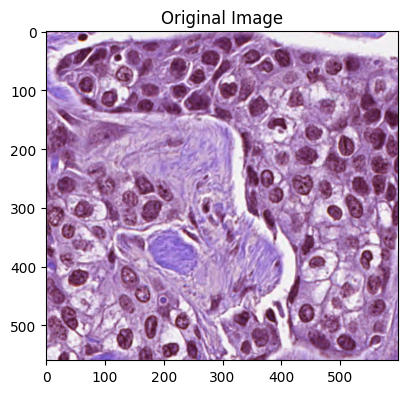

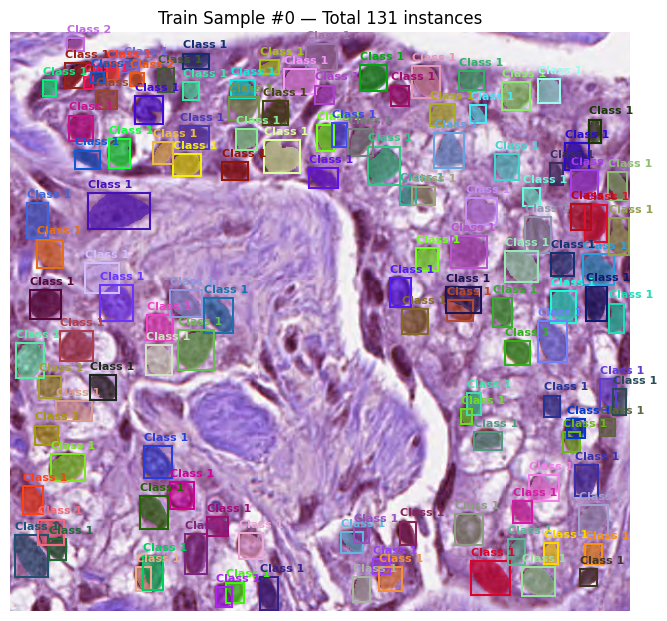

Labels of instances: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2]


In [8]:
# --- 測試 CellDataset 讀取情況 ---
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# 抽一張train資料來看
sample_idx = 0
img, target = full_dataset[sample_idx]

# 顯示原圖
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img.permute(1, 2, 0))  # C,H,W -> H,W,C
plt.title('Original Image')

# 圖片與遮罩
img_np = img.permute(1, 2, 0).numpy()
overlay = img_np.copy()
masks = target['masks'].numpy()
labels = target['labels'].numpy()
boxes = target['boxes'].numpy()

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.imshow(overlay)

for i in range(masks.shape[0]):
    mask = masks[i]
    color = np.random.rand(3)

    # 疊色
    overlay[mask == 1] = overlay[mask == 1] * 0.4 + color * 0.6

    # 取出 box 座標
    x1, y1, x2, y2 = boxes[i]
    width, height = x2 - x1, y2 - y1

    # 畫bounding box
    rect = patches.Rectangle((x1, y1), width, height,
                             linewidth=1.5, edgecolor=color, facecolor='none')
    ax.add_patch(rect)

    # 畫label文字
    ax.text(x1, y1 - 5, f"Class {labels[i]}", color=color, fontsize=8, weight='bold')

# 顯示結果
ax.imshow(overlay)
ax.set_title(f"Train Sample #{sample_idx} — Total {len(labels)} instances")
ax.axis('off')
plt.show()

# 印出 instance 的 class label
print("Labels of instances:", labels.tolist())


In [9]:
# # --- 6. 初始化Mask R-CNN模型 [resnet18]---
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
from torchvision.models.detection import MaskRCNN
backbone = resnet_fpn_backbone('resnet18', pretrained=True)
model = MaskRCNN(backbone, num_classes=5)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'backbone_name' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f370

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(

In [10]:
# --- 7. 優化訓練器設定 --- [added]
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)


In [11]:
# 顯示資料量
print(f"Training images: {len(train_dataset)}")
print(f"Validation images: {len(val_dataset)}")

# 顯示模型參數量
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")


Training images: 188
Validation images: 21

Total parameters: 30,913,261
Trainable parameters: 30,756,397


In [12]:
# --- 8. 訓練過程 ---
num_epochs = 10
best_val_loss = float('inf')
no_improve = 0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for images, targets in tqdm(train_loader):
        images = list(img.to(device) for img in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        train_loss += losses.item()

    scheduler.step()

    model.train()
    val_loss = 0
    with torch.no_grad():
        for images, targets in val_loader:
            images = list(img.to(device) for img in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            val_loss += losses.item()

    print(f"Epoch {epoch}: Train Loss = {train_loss/len(train_loader):.4f}, Val Loss = {val_loss/len(val_loader):.4f}")


    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), '/content/best_model.pth')
        print("Model saved!")
        no_improve = 0
    else:
        no_improve += 1

    if no_improve >= 3:
        print("Early stopping triggered")
        break

    if epoch == 9: # Save checkpoint at epoch 10
        torch.save(model.state_dict(), '/content/model_epoch_10.pth')
        print("Checkpoint saved at epoch 10!")


100%|██████████| 47/47 [01:07<00:00,  1.44s/it]


Epoch 0: Train Loss = 2.2518, Val Loss = 1.6992
Model saved!


100%|██████████| 47/47 [01:02<00:00,  1.33s/it]


Epoch 1: Train Loss = 1.6812, Val Loss = 1.4969
Model saved!


100%|██████████| 47/47 [01:03<00:00,  1.35s/it]


Epoch 2: Train Loss = 1.4852, Val Loss = 1.3445
Model saved!


100%|██████████| 47/47 [01:03<00:00,  1.34s/it]


Epoch 3: Train Loss = 1.3399, Val Loss = 1.3844


100%|██████████| 47/47 [01:02<00:00,  1.33s/it]


Epoch 4: Train Loss = 1.2796, Val Loss = 1.2403
Model saved!


100%|██████████| 47/47 [01:03<00:00,  1.35s/it]


Epoch 5: Train Loss = 1.2165, Val Loss = 1.1919
Model saved!


100%|██████████| 47/47 [01:02<00:00,  1.33s/it]


Epoch 6: Train Loss = 1.1562, Val Loss = 1.1762
Model saved!


100%|██████████| 47/47 [01:02<00:00,  1.33s/it]


Epoch 7: Train Loss = 1.1241, Val Loss = 1.1653
Model saved!


100%|██████████| 47/47 [01:02<00:00,  1.33s/it]


Epoch 8: Train Loss = 1.0974, Val Loss = 1.1893


100%|██████████| 47/47 [01:02<00:00,  1.33s/it]


Epoch 9: Train Loss = 1.0648, Val Loss = 1.1081
Model saved!
Checkpoint saved at epoch 10!


In [13]:
# Load the checkpoint at epoch 10
checkpoint_path = '/content/model_epoch_10.pth'
model.load_state_dict(torch.load(checkpoint_path))
print(f"Checkpoint loaded from {checkpoint_path}")

# Continue training from epoch 10
num_epochs_continued = 20 # Example: Continue training for 20 epochs
for epoch in range(10, num_epochs_continued + 10):
    model.train()
    train_loss = 0
    for images, targets in tqdm(train_loader):
        images = list(img.to(device) for img in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        train_loss += losses.item()

    scheduler.step()

    model.train() # Set to eval mode for validation
    val_loss = 0
    with torch.no_grad():
        for images, targets in val_loader:
            images = list(img.to(device) for img in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            val_loss += losses.item()

    print(f"Epoch {epoch}: Train Loss = {train_loss/len(train_loader):.4f}, Val Loss = {val_loss/len(val_loader):.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), '/content/best_model.pth')
        print("Model saved!")
        no_improve = 0
    else:
        no_improve += 1

    if no_improve >= 3:
        print("Early stopping triggered")
        break

    if epoch == 19: # Save checkpoint at epoch 10
        torch.save(model.state_dict(), '/content/model_epoch_20.pth')
        print("Checkpoint saved at epoch 20!")


Checkpoint loaded from /content/model_epoch_10.pth


100%|██████████| 47/47 [01:02<00:00,  1.34s/it]


Epoch 10: Train Loss = 1.0448, Val Loss = 1.1336


100%|██████████| 47/47 [01:02<00:00,  1.33s/it]


Epoch 11: Train Loss = 1.0358, Val Loss = 1.0952
Model saved!


100%|██████████| 47/47 [01:03<00:00,  1.34s/it]


Epoch 12: Train Loss = 1.0144, Val Loss = 1.1143


100%|██████████| 47/47 [01:03<00:00,  1.35s/it]


Epoch 13: Train Loss = 1.0106, Val Loss = 1.1179


100%|██████████| 47/47 [01:03<00:00,  1.35s/it]


Epoch 14: Train Loss = 0.9981, Val Loss = 1.1299
Early stopping triggered


  0%|          | 0/101 [00:00<?, ?it/s]

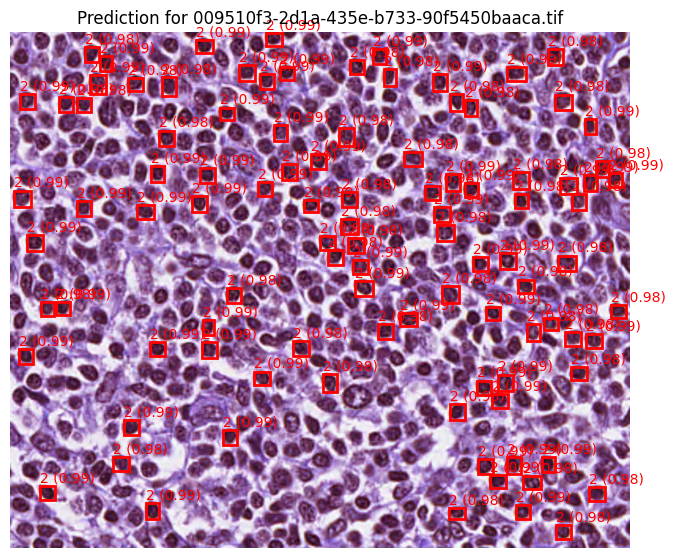

  1%|          | 1/101 [00:00<01:19,  1.25it/s]

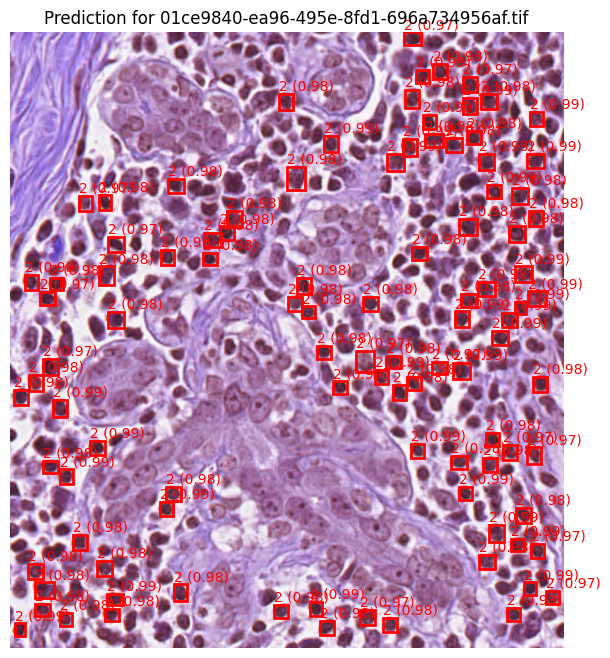

  2%|▏         | 2/101 [00:01<01:23,  1.18it/s]

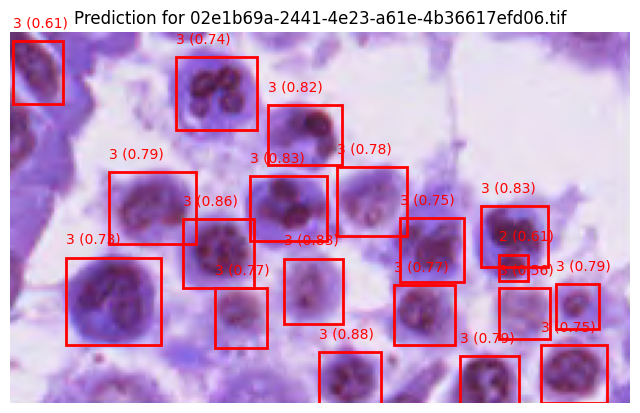

  3%|▎         | 3/101 [00:02<01:01,  1.59it/s]

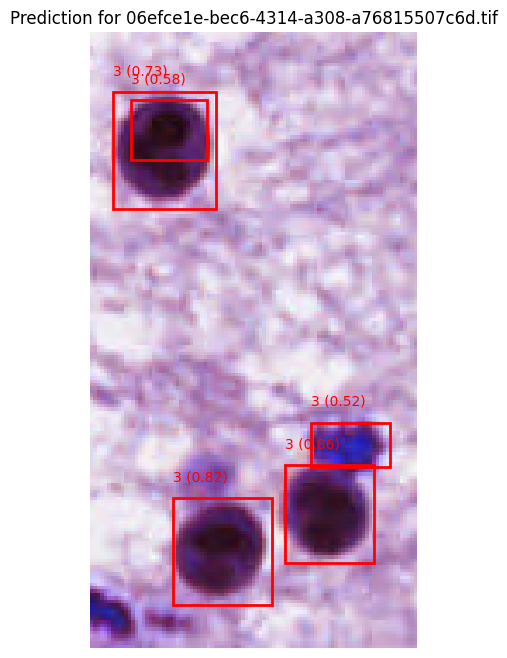

  4%|▍         | 4/101 [00:02<00:44,  2.20it/s]

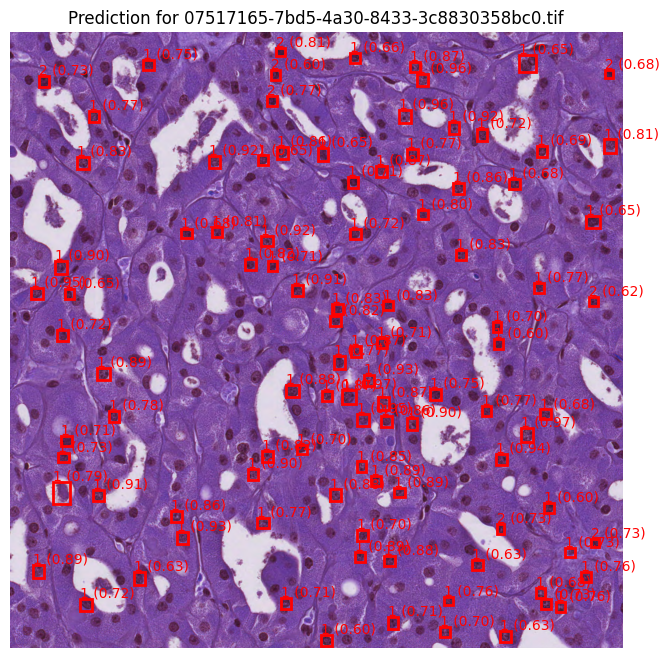

100%|██████████| 101/101 [00:25<00:00,  3.94it/s]

test-results.json已產生！


In [14]:
# --- 9. 推論Test圖片（使用最佳模型）並產生test-results.json ---
class TestDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images = sorted(os.listdir(root_dir))

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.images[idx])
        img = Image.open(img_path).convert('RGB')
        img = TF.to_tensor(img)
        return img, self.images[idx]

    def __len__(self):
        return len(self.images)

# 讀取test image id對應表
with open(os.path.join(extract_folder, 'test_image_name_to_ids.json'), 'r') as f:
    id_map = {d['file_name']: d['id'] for d in json.load(f)}

# 重新載入最佳模型
model.load_state_dict(torch.load('/content/best_model.pth'))
model.eval()

test_dataset = TestDataset(os.path.join(extract_folder, 'test_release'))
test_loader = DataLoader(test_dataset, batch_size=1)

results = []

with torch.no_grad():
    for idx, (images, filenames) in enumerate(tqdm(test_loader)):
        images = list(img.to(device) for img in images)
        outputs = model(images)

        for output, filename in zip(outputs, filenames):
            image_id = id_map[filename]

            for box, label, score, mask in zip(output['boxes'], output['labels'], output['scores'], output['masks']):
                if score < 0.5:
                    continue
                x1, y1, x2, y2 = box.tolist()
                width, height = x2 - x1, y2 - y1
                binary_mask = mask.squeeze(0).cpu().numpy() > 0.5
                rle = encode_mask(binary_mask)

                results.append({
                    'image_id': image_id,
                    'bbox': [x1, y1, width, height],
                    'score': float(score.cpu()),
                    'category_id': int(label.cpu()),
                    'segmentation': rle
                })

            # 額外顯示前 5 張的結果
            if idx < 5:
                image = images[0].permute(1, 2, 0).cpu().numpy()
                fig, ax = plt.subplots(1, 1, figsize=(8, 8))
                ax.imshow(image)
                for box, label, score in zip(output['boxes'], output['labels'], output['scores']):
                    if score < 0.5:
                        continue
                    x1, y1, x2, y2 = box.tolist()
                    w, h = x2 - x1, y2 - y1
                    rect = patches.Rectangle((x1, y1), w, h, linewidth=2, edgecolor='r', facecolor='none')
                    ax.add_patch(rect)
                    ax.text(x1, y1 - 5, f"{label.item()} ({score:.2f})", color='red', fontsize=10)
                ax.set_title(f"Prediction for {filename}")
                ax.axis('off')
                plt.show()

# 儲存結果
with open('test-results.json', 'w') as f:
    json.dump(results, f)

print("test-results.json已產生！")


In [16]:
from google.colab import files
files.download('test-results.json')
files.download('/content/best_model.pth')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>